# Manifold Learning


principal component analysis (PCA) can be used in the dimensionality reduction task—reducing the number of features of a dataset while maintaining the essential relationships between the points.

- While PCA is flexible, fast, and somewhat interpretable, it does not perform so well when there are nonlinear relationships


**manifold learning** — a class of unsupervised estimators that seeks to describe datasets as low-dimensional manifolds embedded in high-dimensional spaces.


![](figs/rolled_sheet_paper.jpg)


- A sheet of paper lives in a 3d world but lies on a 2d manifold
- Manifold unfolding tries to learn this
- No matter how you bend, rotate, curl or crumple the paper it still lives on a 2d manifold


**Manifold learning algorithms would seek to learn about the fundamental two-dimensional nature of the paper, even as it is contorted to fill the three-dimensional space.**


## Import functions


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from mpl_toolkits.mplot3d.art3d import Line3DCollection

import seaborn as sns
sns.set()
import numpy as np
import umap

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_openml, fetch_lfw_people
from sklearn.manifold import Isomap, LocallyLinearEmbedding, MDS
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances


from mpl_toolkits import mplot3d


### Manifold Learning: "HELLO"

To make these concepts more clear, let's start by generating some two-dimensional data that we can use to define a manifold.
Here is a function that will create data in the shape of the word "HELLO":


In [2]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

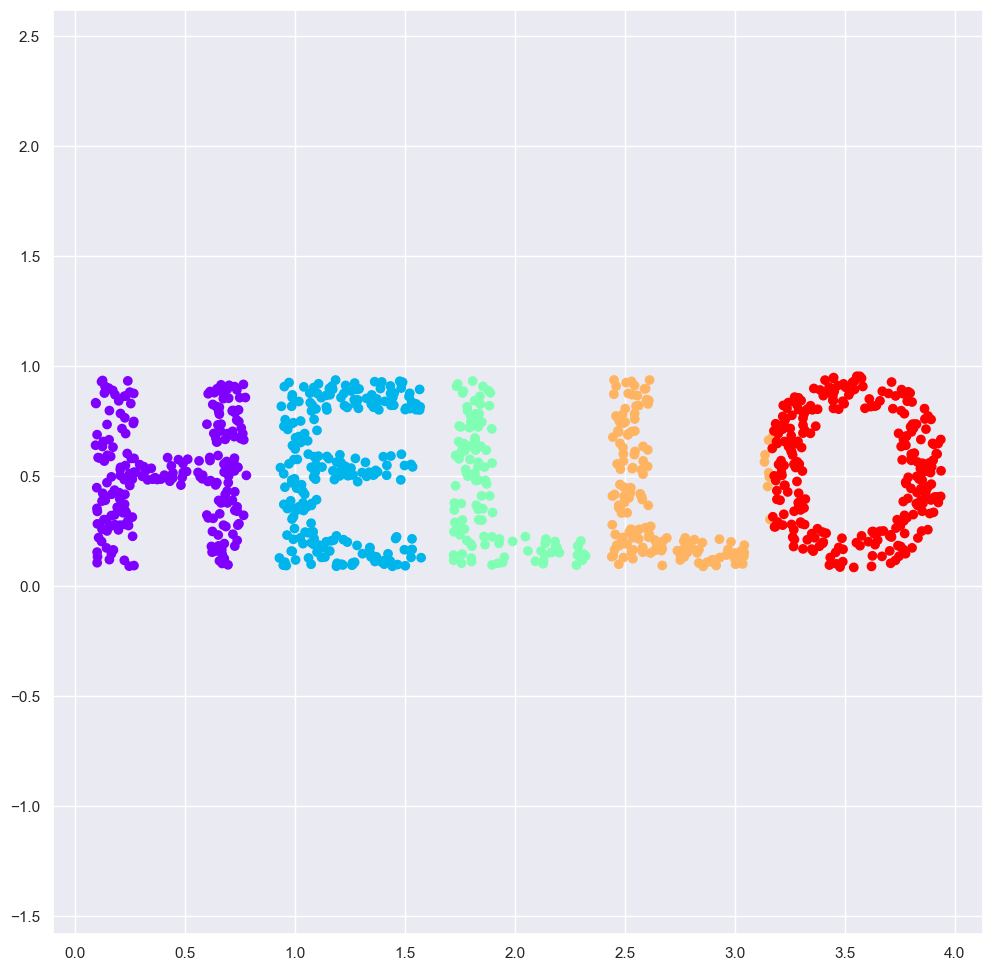

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
fig=plt.figure(figsize=(12, 12))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

### Multidimensional Scaling (MDS)

- The choice of _x_ and _y_ values of the dataset is not the most fundamental description of the data: we can scale, shrink, or rotate the data, and the "HELLO" will still be apparent.
- If we use a rotation matrix to rotate the data, the _x_ and _y_ values change, but the data is still fundamentally the same:


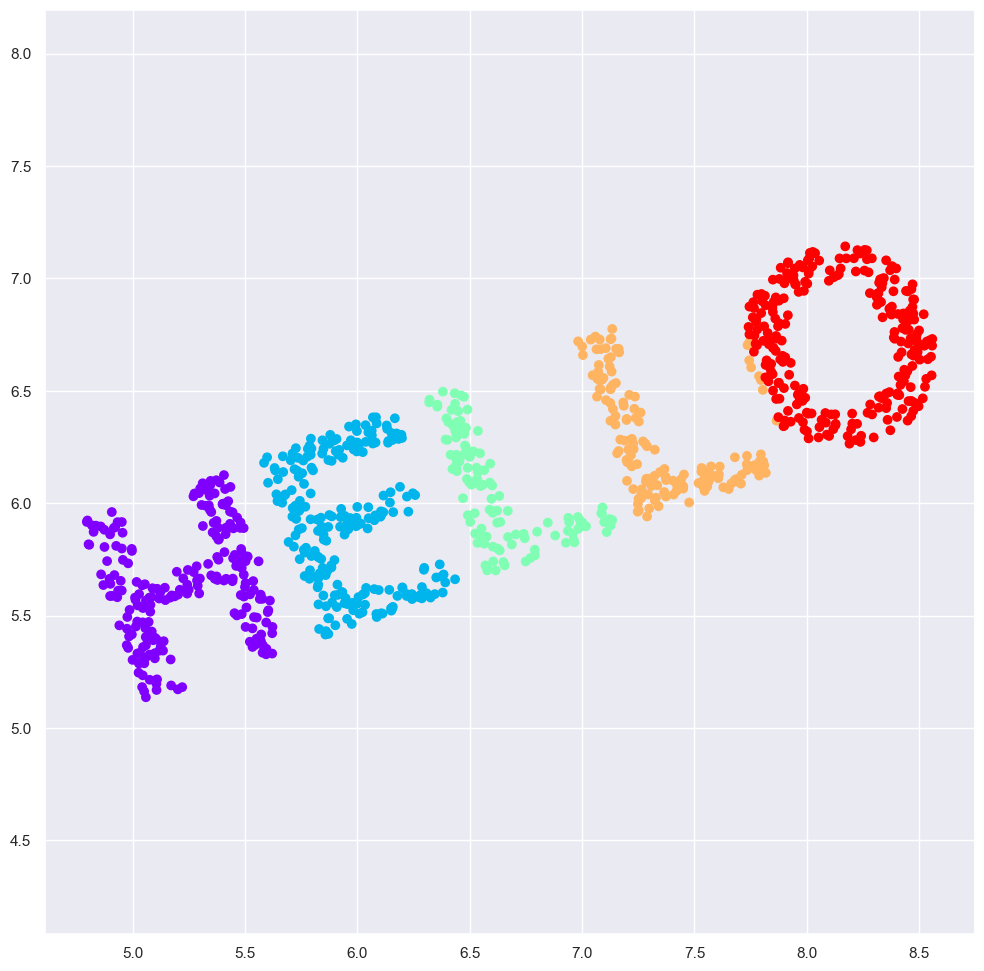

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
fig=plt.figure(figsize=(12, 12))
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

- _x_ and _y_ values are not necessarily fundamental to the relationships in the data.
- What _is_ fundamental, in this case, is the _distance_ between each point and the other points in the dataset.
- A common way to represent this is to use a distance matrix: for $N$ points, we construct an $N \times N$ array such that entry $(i, j)$ contains the distance between point $i$ and point $j$.

Let's use Scikit-Learn's efficient `pairwise_distances` function to do this for our original data:


**Pairwise Distance Calculation**


In [5]:
D = pairwise_distances(X)
D.shape

(1000, 1000)

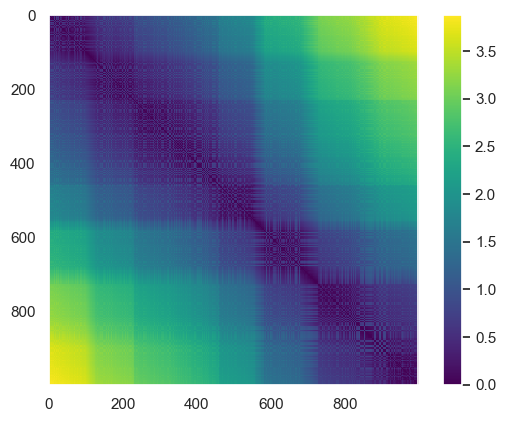

In [6]:
plt.imshow(D, zorder=2, cmap='viridis', interpolation='nearest')
plt.colorbar();

If we similarly construct a distance matrix for our rotated and translated data, we see that it is the same:


In [7]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

- This means that the pairwise distance is invariant to rotations


- This representation no longer looks like Hello


- Transforming a distance matrix back to real space is difficult


**Multidimensional scaling**


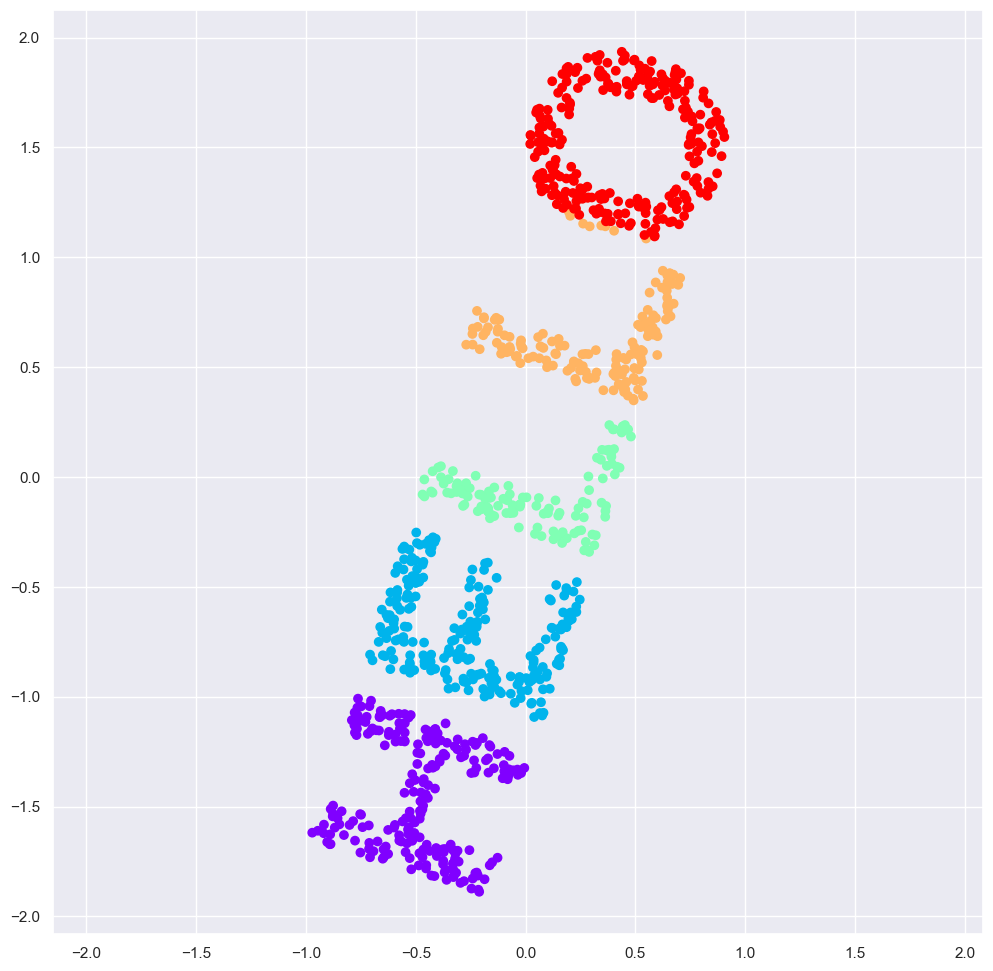

In [8]:
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
fig=plt.figure(figsize=(12, 12))
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

The MDS algorithm recovers one of the possible two-dimensional coordinate representations of our data, using _only_ the $N\times N$ distance matrix describing the relationship between the data points.


**MDS as Manifold Learning**

- The usefulness of this becomes more apparent when we consider the fact that distance matrices can be computed from data in _any_ dimension.

So, for example, instead of simply rotating the data in the two-dimensional plane, we can project it into three dimensions using the following function (essentially a three-dimensional generalization of the rotation matrix used earlier):


In [9]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

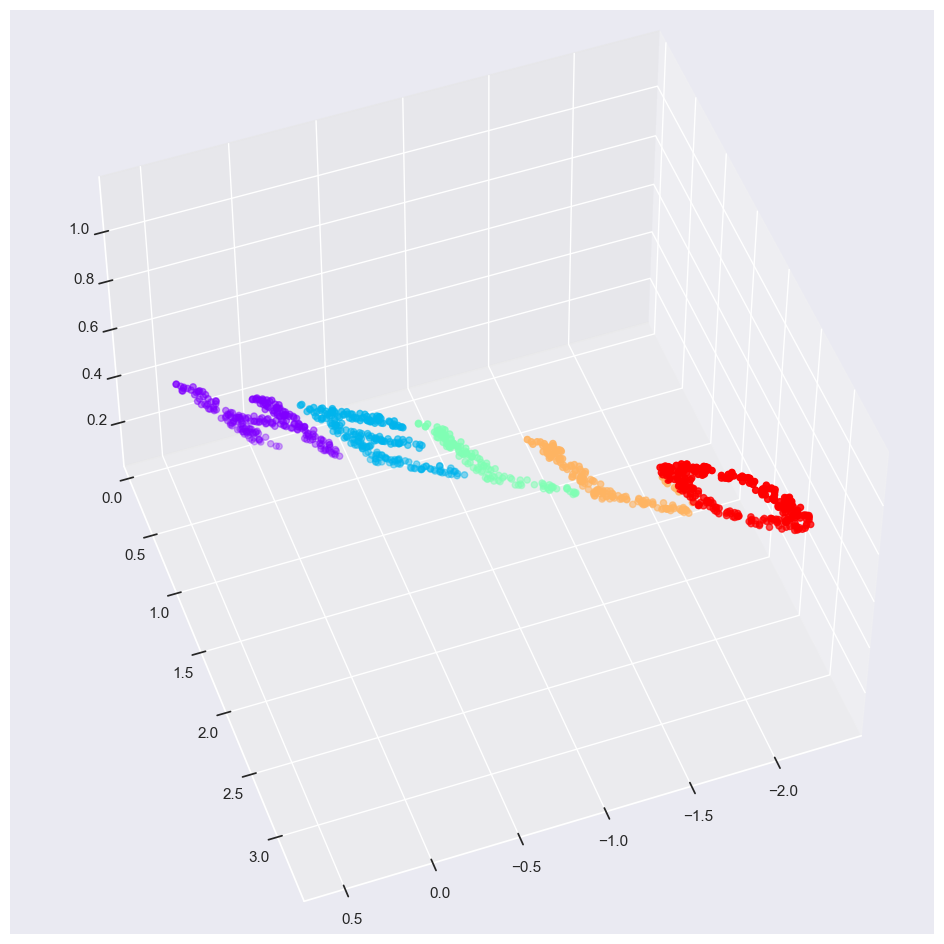

In [10]:
fig=plt.figure(figsize=(12, 12))

ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

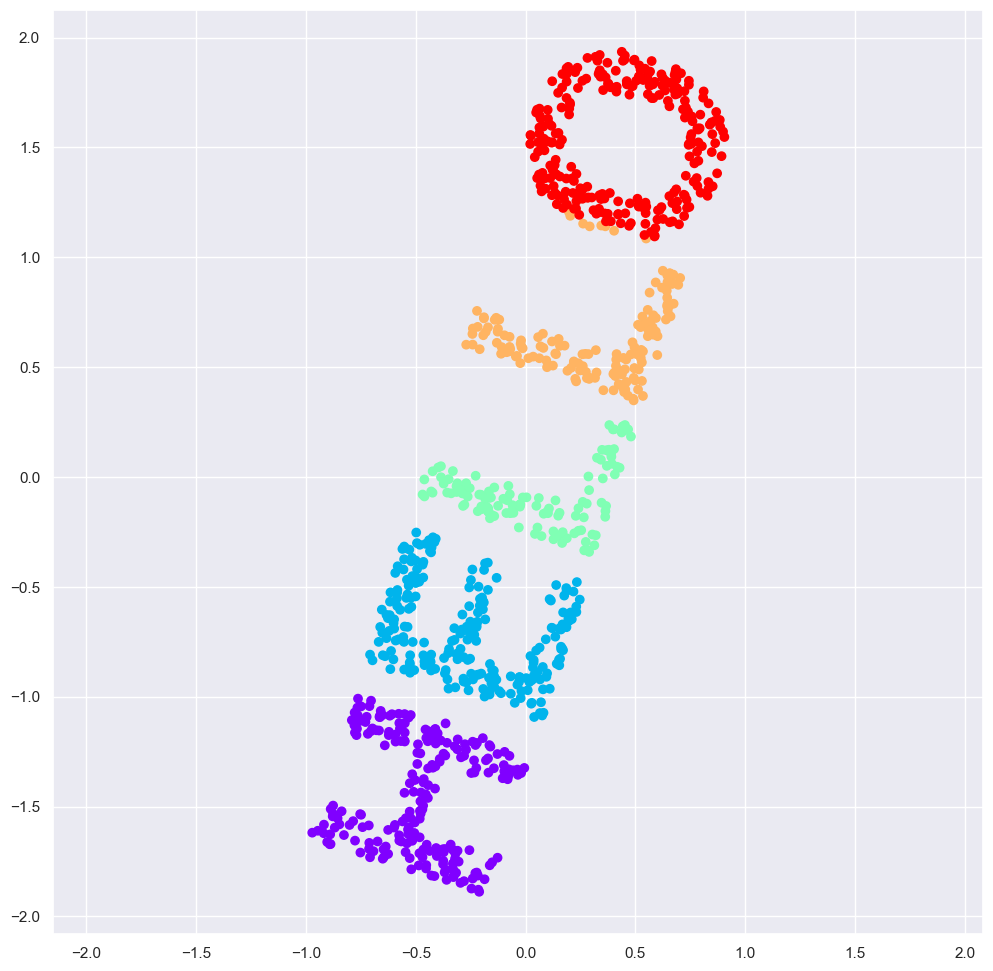

In [11]:
model = MDS(n_components=2, random_state=1)
fig=plt.figure(figsize=(12, 12))
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

**Multidimensional Scaling still recovers the image!!!**


This is essentially the goal of a manifold learning estimator: given
high-dimensional embedded data, it seeks a low-dimensional representation of the data that preserves certain relationships within the data.
In the case of MDS, the quantity preserved is the distance between every pair of points.


**Nonlinear Embeddings: Where MDS Fails**


- The word "Hello" has linear relationships between datapoints
- _linear_ embeddings, which essentially consist of rotations, translations, and scalings of data into higher-dimensional spaces.


- Where MDS breaks down is when the embedding is nonlinear—that is, when it goes beyond this simple set of operations.


Consider the following embedding, which takes the input and contorts it into an "S" shape in three dimensions:


In [12]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

Again this is 3d data but the manifold is much more complicated


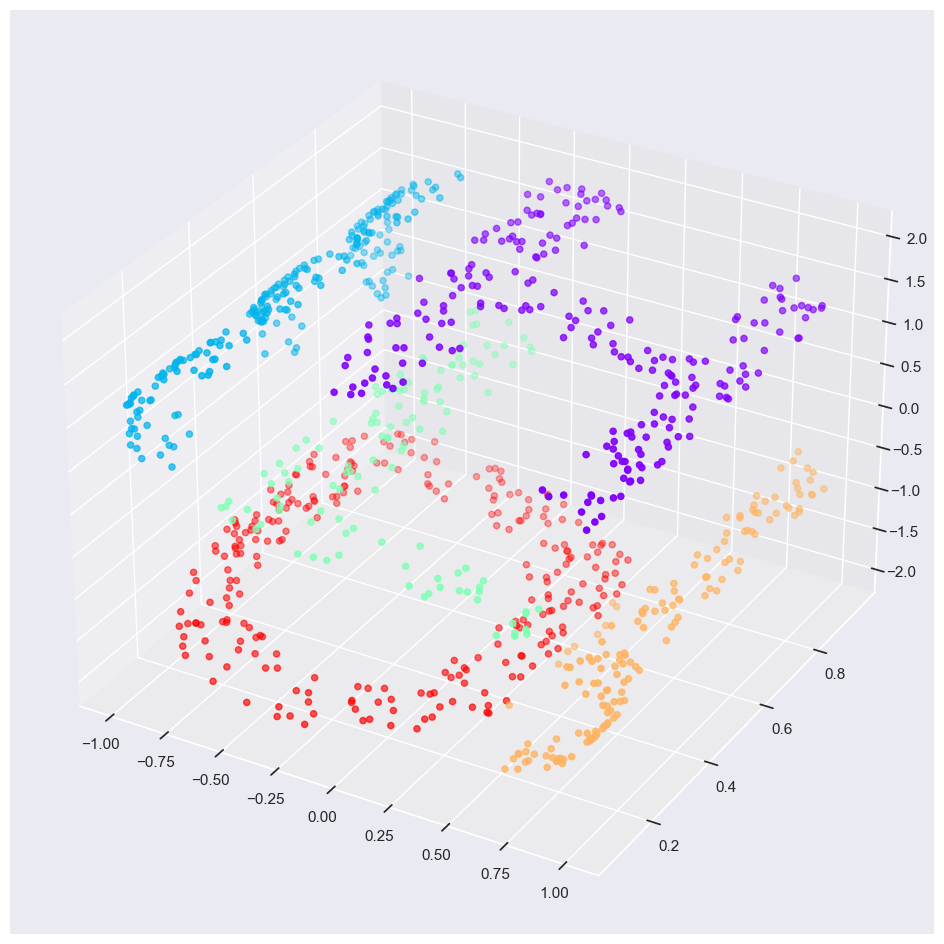

In [13]:
from mpl_toolkits import mplot3d
fig=plt.figure(figsize=(12, 12))

ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

The relationships between the data points are still the same but it has been wrapped into a shape of an S


If we try MDS we are not able to unwrap this nonlinear embedding


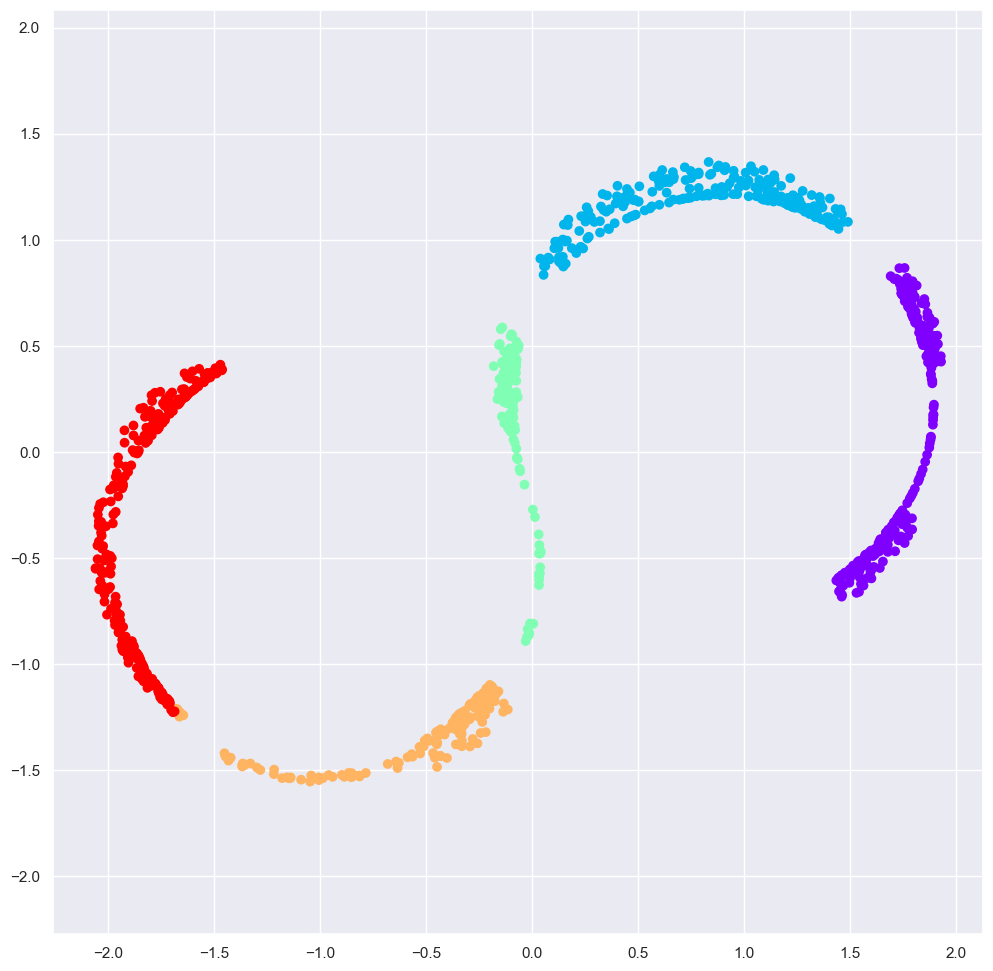

In [14]:
from sklearn.manifold import MDS
fig=plt.figure(figsize=(12, 12))

model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

The best two-dimensional _linear_ embedding does not unwrap the S-curve, but instead throws out the original y-axis.


## Nonlinear Manifolds: Locally Linear Embedding

How can we move forward here?

- we can see that the source of the problem is that MDS tries to preserve distances between faraway points when constructing the embedding.


- If we instead modified the algorithm such that it only preserves distances between nearby points?


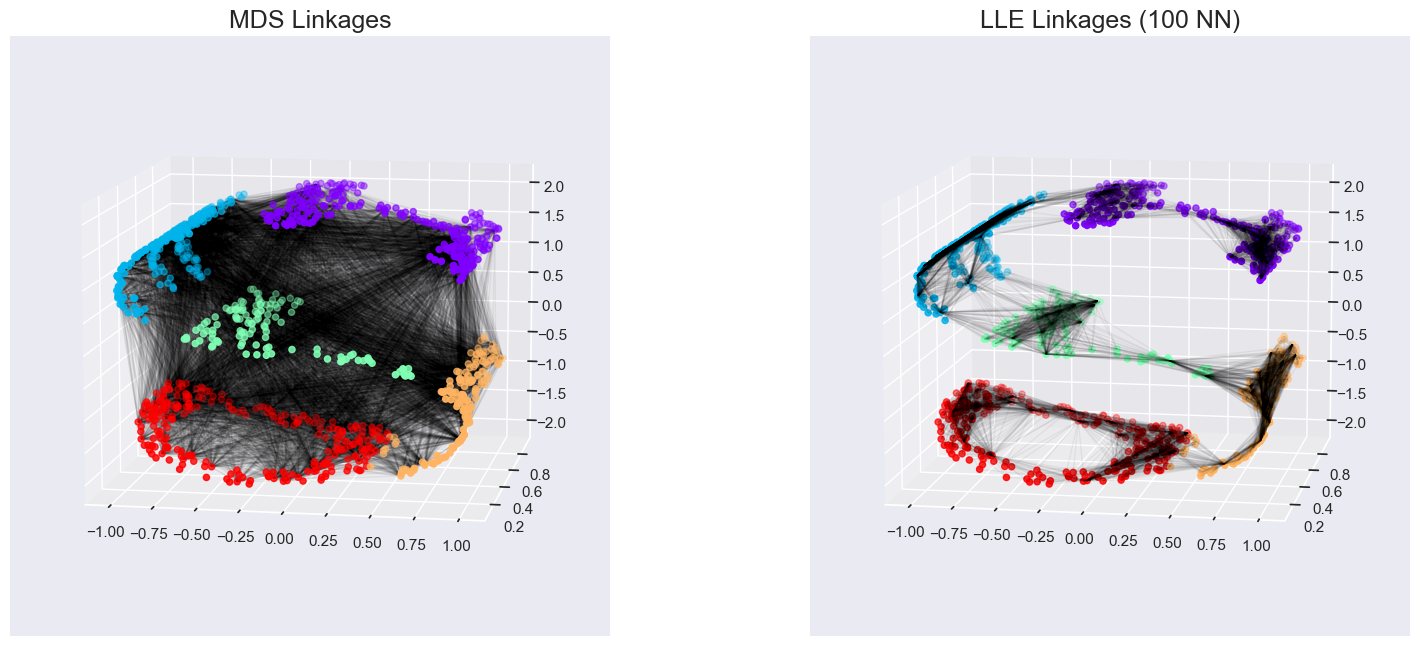

In [15]:


# construct lines for MDS
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
lines_MDS = [(XS[i], XS[j]) for i in ind[:100] for j in ind[100:200]]

# construct lines for LLE
nbrs = NearestNeighbors(n_neighbors=100).fit(XS).kneighbors(XS[ind[:100]])[1]
lines_LLE = [(XS[ind[i]], XS[j]) for i in range(100) for j in nbrs[i]]
titles = ['MDS Linkages', 'LLE Linkages (100 NN)']

# plot the results
fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(projection='3d'))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)

for axi, title, lines in zip(ax, titles, [lines_MDS, lines_LLE]):
    axi.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize);
    axi.add_collection(Line3DCollection(lines, lw=1, color='black',
                                        alpha=0.05))
    axi.view_init(elev=10, azim=-80)
    axi.set_title(title, size=18)

- The faint lines represents the distances that should be preserved


**MDS:** it tries to preserve the distances between each pair of points in the dataset. <br>
**Local linear embedding (LLE):** rather than preserving _all_ distances, it instead tries to preserve only the distances between _neighboring points_: in this case, the nearest 100 neighbors of each point.


- LLE comes in a number of flavors; here we will use the _modified LLE_ algorithm to recover the embedded two-dimensional manifold.


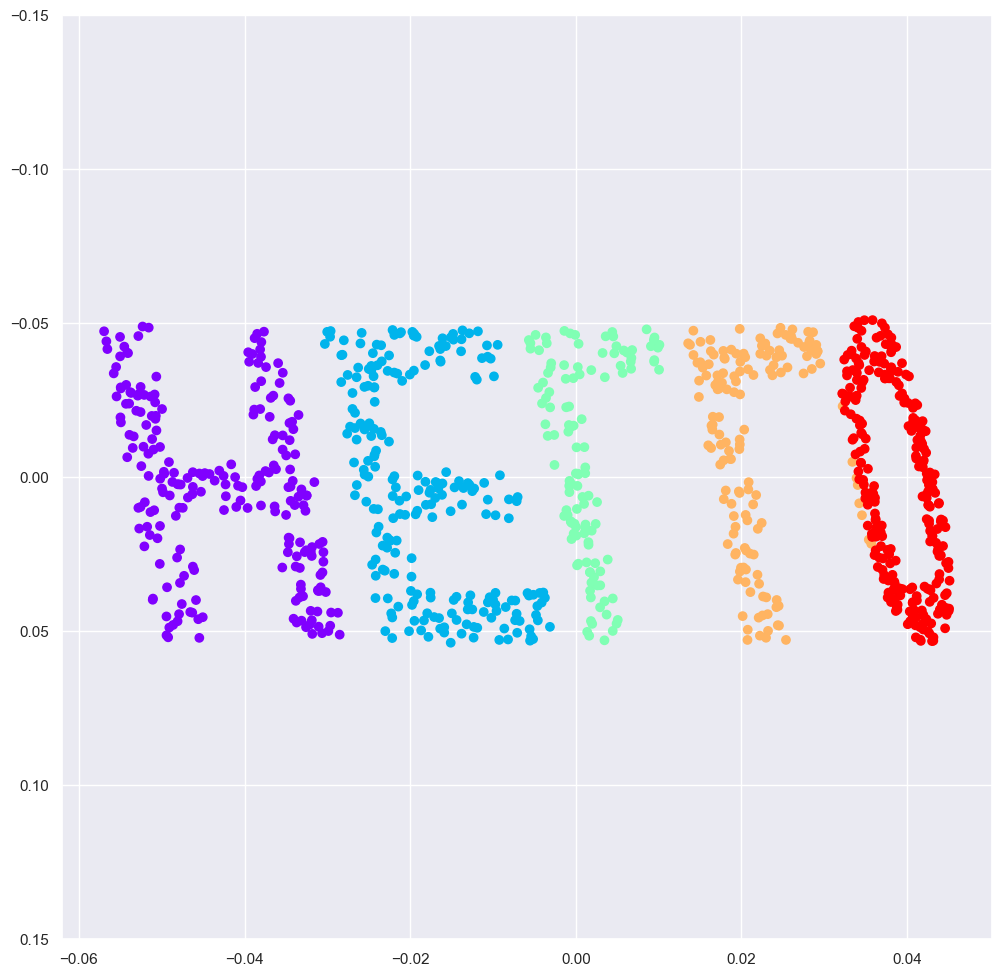

In [16]:

model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)


fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

## Thoughts on Manifold Methods


Though this story and motivation is compelling, in practice manifold learning techniques tend to be finicky enough that they are rarely used for anything more than simple qualitative visualization of high-dimensional data.


The following are some of the particular challenges of manifold learning, which all contrast poorly with PCA:


- In manifold learning, there is no good framework for handling missing data. In contrast, there are straightforward iterative approaches for missing data in PCA.


- In manifold learning, the presence of noise in the data can "short-circuit" the manifold and drastically change the embedding. In contrast, PCA naturally filters the noise from the most important components.


- The manifold embedding result is generally highly dependent on the number of neighbors chosen, and there is generally no solid quantitative way to choose an optimal number of neighbors. In contrast, PCA does not involve such a choice.


- In manifold learning, the globally optimal number of output dimensions is difficult to determine. In contrast, PCA lets you find the output dimension based on the explained variance.


- In manifold learning, the meaning of the embedded dimensions is not always clear. In PCA, the principal components have a very clear meaning.


- In manifold learning the computational expense of manifold methods scales as O[N^2] or O[N^3]. For PCA, there exist randomized approaches that are generally much faster


With all that on the table, the only clear advantage of manifold learning methods over PCA is their ability to preserve nonlinear relationships in the data

**For that reason, you should** explore data with manifold methods only after first exploring them with PCA.**


Scikit-Learn implements several common variants of manifold learning beyond Isomap and LLE: the Scikit-Learn documentation has a [nice discussion and comparison of them](http://scikit-learn.org/stable/modules/manifold.html).
Based on my own experience, I would give the following recommendations:

- For toy problems such as the S-curve we saw before, locally linear embedding (LLE) and its variants (especially _modified LLE_), perform very well. This is implemented in `sklearn.manifold.LocallyLinearEmbedding`.
- For high-dimensional data from real-world sources, LLE often produces poor results, and isometric mapping (IsoMap) seems to generally lead to more meaningful embeddings. This is implemented in `sklearn.manifold.Isomap`
- For data that is highly clustered, _t-distributed stochastic neighbor embedding_ (t-SNE) seems to work very well, though can be very slow compared to other methods. This is implemented in `sklearn.manifold.TSNE`. <br> **T-SNE is particularly good for visualizing neural networks which tend to cluster information.**
- For large datasets that are highly clustered, performance is important. U-Map is a drop in replacement for T-SNE that has much better scalable performance. https://umap-learn.readthedocs.io/en/latest/basic_usage.html


![](figs/Umap_performance.png)


## Example: Manifold Unfolding


One place manifold learning is often used is in understanding the relationship between high-dimensional data points.

- A common case of high-dimensional data is images: for example, a set of images with 1,000 pixels each can be thought of as a collection of points in 1,000 dimensions – the brightness of each pixel in each image defines the coordinate in that dimension.

Here let's apply Isomap on some faces data.

Running this command will download the data and cache it in your home directory for later use:


In [17]:
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

We have 2,370 images, each with 2,914 pixels.

- Images can be thought of as data points in a 2,914-dimensional space!

Let's quickly visualize several of these images to see what we're working with:


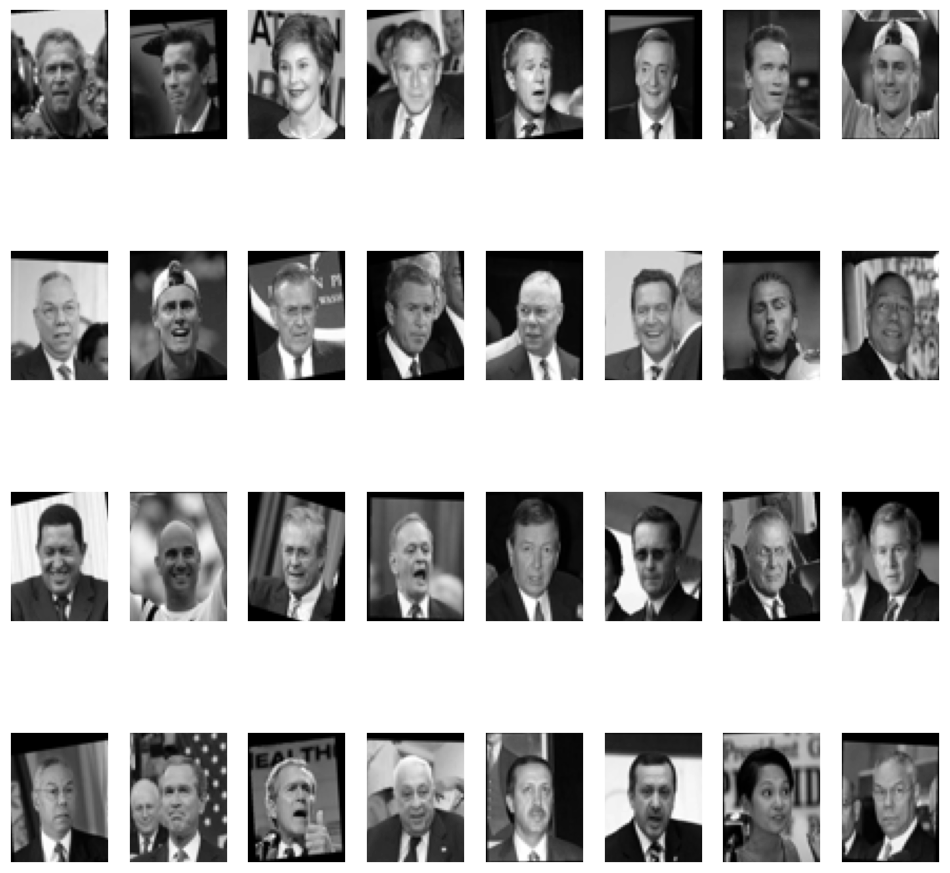

In [18]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]), figsize=(12,12))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

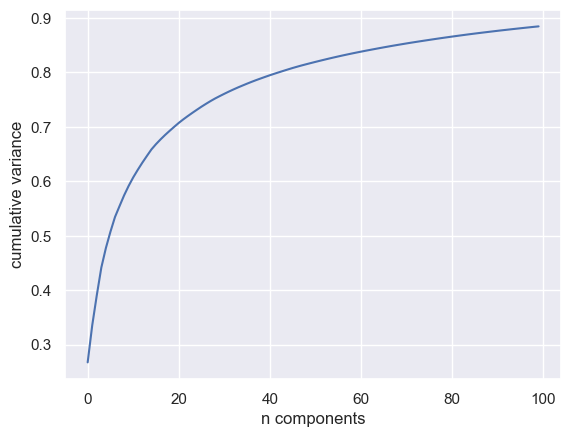

In [19]:

model = PCA(100, svd_solver='randomized').fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

- It requires at least 100 components to explain 90% of the data
  - This means the information is intrinsically high dimensional
  - The data does not lie on a linear manifold


### Isomap


In [20]:

model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

The output is a two-dimensional projection of all the input images. <br>
To get a better idea of what the projection tells us, let's define a function that will output image thumbnails at the locations of the projections:


In [21]:


def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

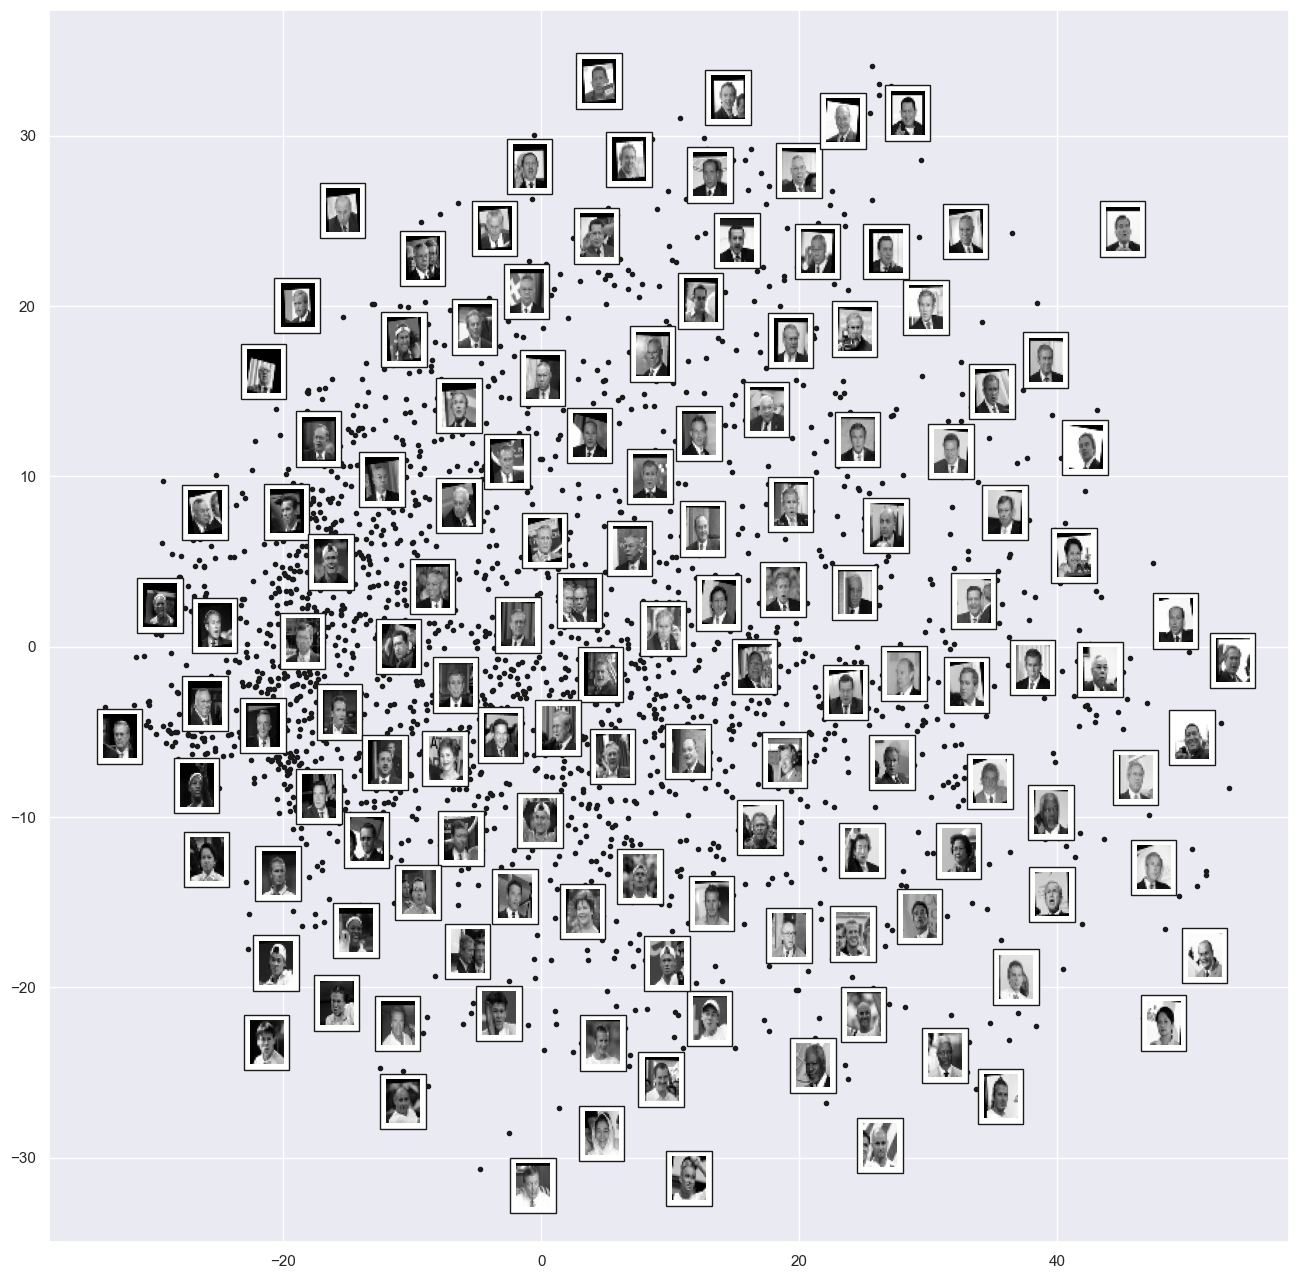

In [22]:
fig, ax = plt.subplots(figsize=(16, 16))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

Takeaways:

1. left-to-right contains the darkness of the image
2. Top-to-bottom contains the orientation of the images

We could use this manifold as features to classify these images


## Example: Visualizing MNIST with manifold unfolding


In [23]:

mnist = fetch_openml('mnist_784', version=1, cache=True)

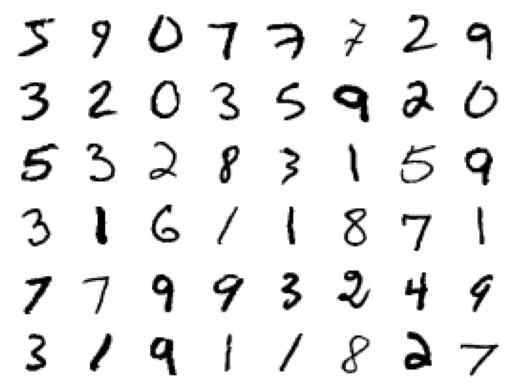

In [24]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data.loc[1250 * i].to_numpy().reshape(28, 28), cmap='gray_r')

### Manifold Learning of MNIST

- Can only use 1/30 of the dataset due to computational time


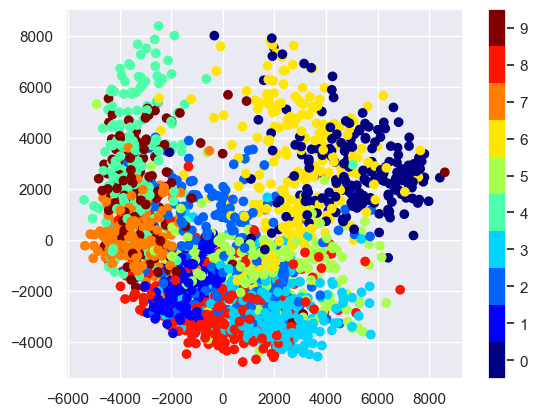

In [25]:


# use only 1/30 of the data: full dataset takes a long time!
data = mnist.data[::30]
target = mnist.target[::30].astype(int)

model = Isomap(n_components=2)
proj = model.fit_transform(data)
scaler = MinMaxScaler()
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet',10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

The resulting scatter plot shows some of the relationships between the data points, but is a bit crowded.
We can gain more insight by looking at just a single number at a time:


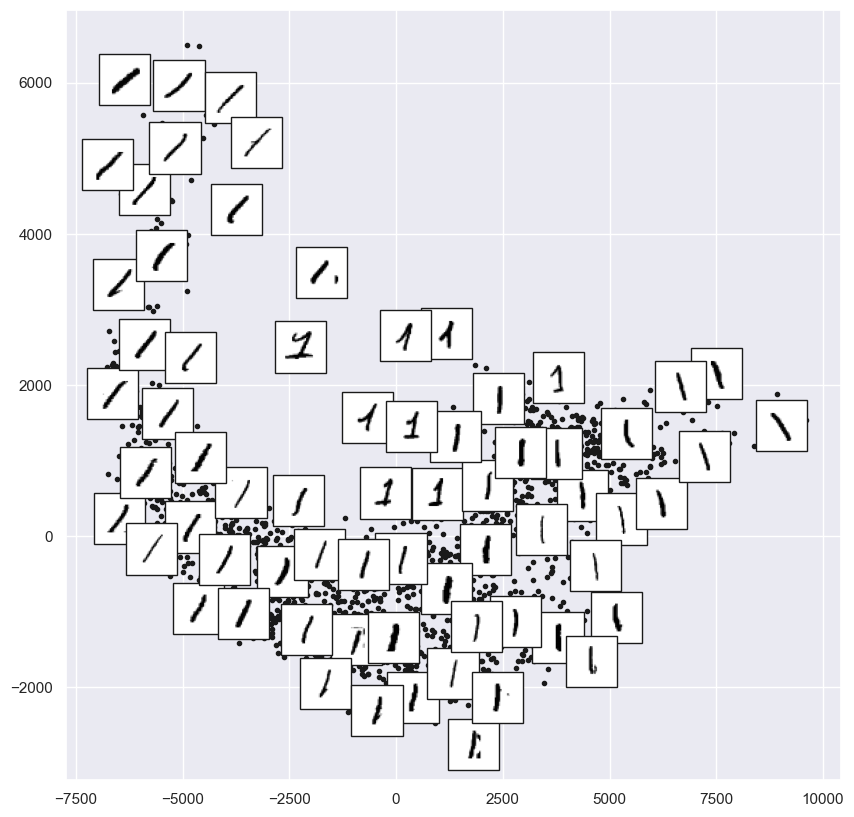

In [26]:
from sklearn.manifold import Isomap

# Choose 1/4 of the "1" digits to project
data = mnist.data[mnist.target.astype(int) == 1][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.to_numpy().reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

The result gives you an idea of the variety of forms that the number "1" can take within the dataset.
The data lies along a broad curve in the projected space, which appears to trace the orientation of the digit.
As you move up the plot, you find ones that have hats and/or bases, though these are very sparse within the dataset.
The projection lets us identify outliers that have data issues: for example, pieces of the neighboring digits that snuck into the extracted images.

Now, this in itself may not be useful for the task of classifying digits, but it does help us get an understanding of the data, and may give us ideas about how to move forward, such as how we might want to preprocess the data before building a classification pipeline.


## T-Stochastic Nearest Neighbor Embeddings

- T-SNE is really useful to try and understand the learning processes in neural networks. It can simplify high-dimensional layers into something that is interpretable.


c:\Users\jca92\.conda\envs\jupyterbook\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\jca92\.conda\envs\jupyterbook\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


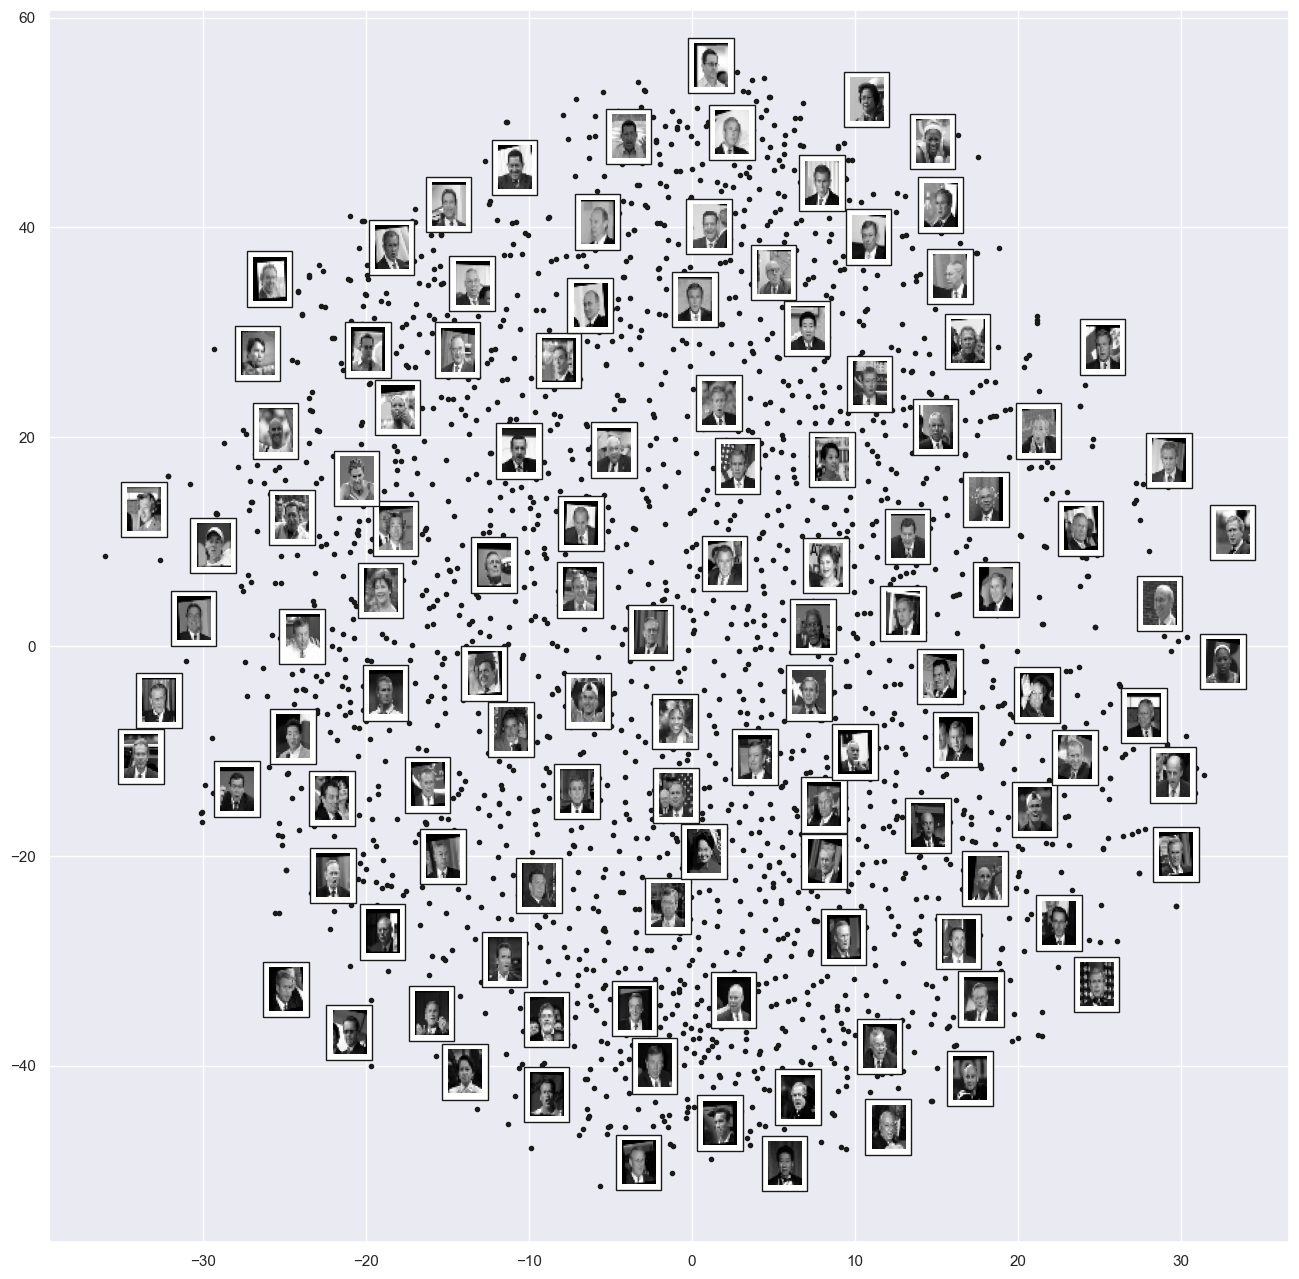

In [27]:
fig, ax = plt.subplots(figsize=(16, 16))
plot_components(faces.data,
                model=TSNE(n_components=2),
                images=faces.images[:, ::2, ::2])

### Uniform Manifold Approximation and Projection (UMAP)

- U-Map is a better and faster version of T-sne. If you are interested in learning more please look at the [manuscript](https://arxiv.org/abs/1802.03426)


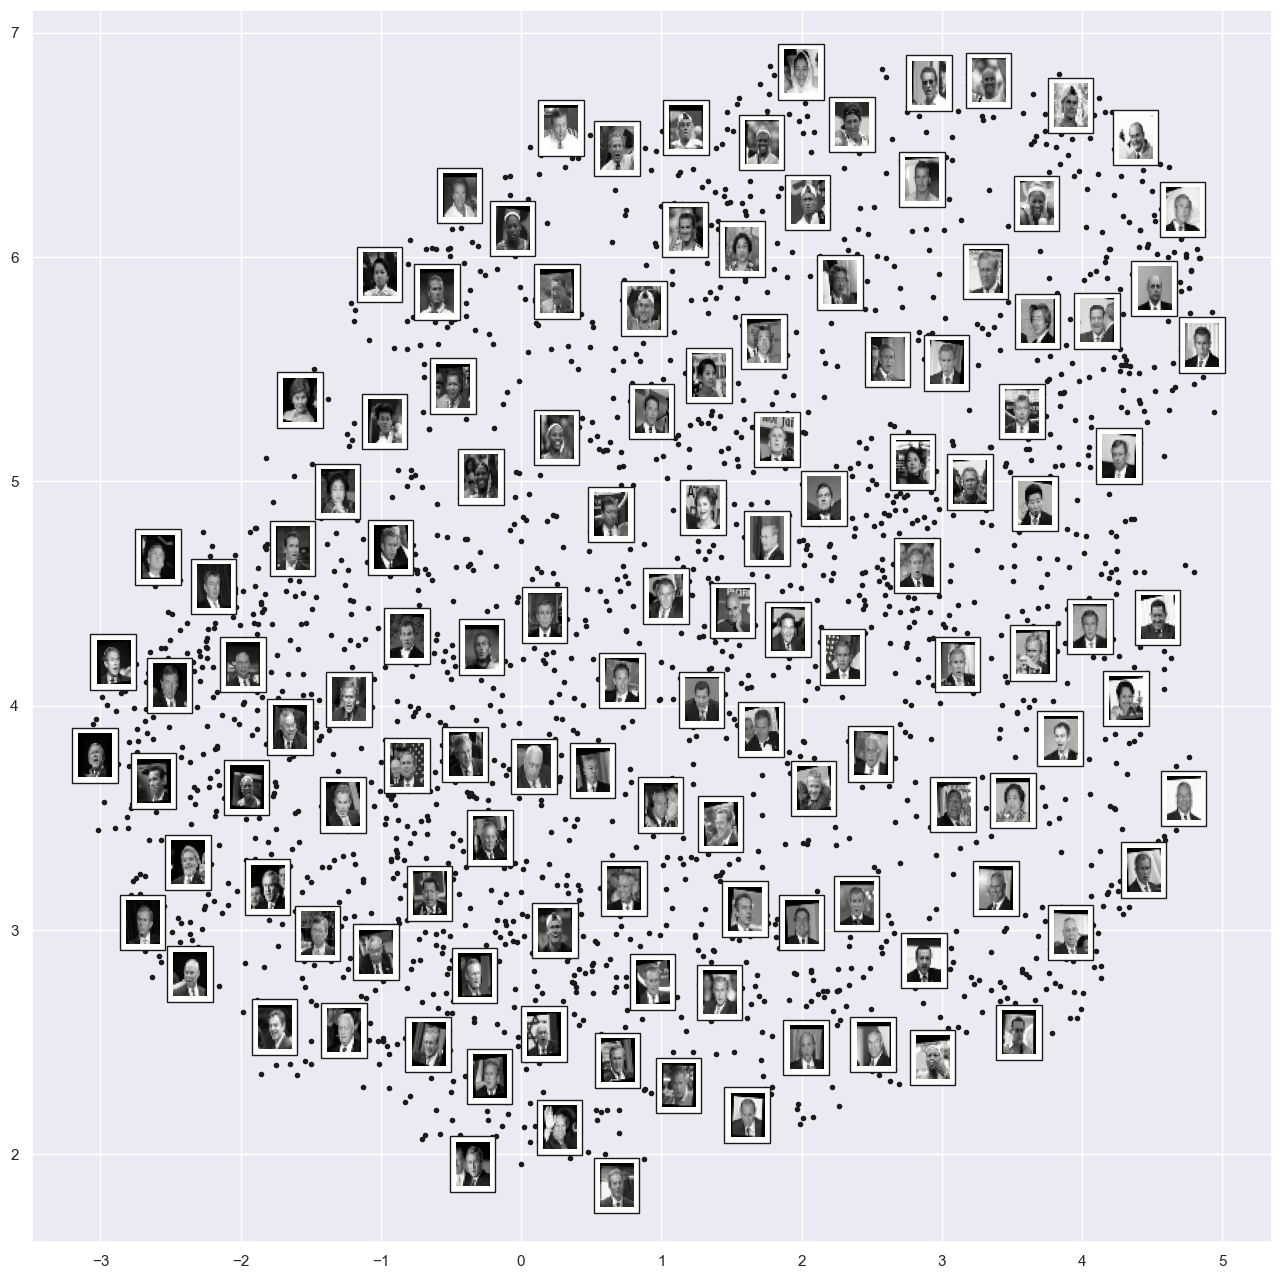

In [28]:
reducer = umap.UMAP

fig, ax = plt.subplots(figsize=(16, 16))
plot_components(faces.data,
                model=reducer(n_components=2),
                images=faces.images[:, ::2, ::2])